# Training locality sensitive model for regression on AChEi dataset
Things to check with Dr Gearhart:
- Original dataset (SMILES or other form of unique identifier besides Mol_ID) : Check supplementary material Table I of Ruark's paper

- source identifier
- how to calculate temperature normalized logKi (Temperature is missing in null values)

Possible comparisons:
Orthogonal projection to latent structures regression, bootstrap leave random-many-out cross-validation and y-randomization were used to develop an externally validated consensus QSAR model.

ways to identify activity cliffs (Guha & Van Drie 2008),

In [1]:
import os, sys
import pandas as pd
import numpy as np

df=pd.read_csv(os.path.join("..",
                            "..",
                            "rawdata",
                            "OP_extended_AKD2.csv"
                           ),
               index_col=0
              )

In [2]:
df.head()

,﻿ID,source,Species,Normalized_temp_logki,Temperature,MOL_ID,logki,MW,AMW,Sv,...,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50,BLTF96,BLTD48,BLTA96,ALOGPS_logP,ALOGPS_logS
Row Id,,,,,,,,,,,,,,,,,,,,,
0,1,a,A,2.34,25.0,C13H13SPO,2.34,248.30,8.56,19.67,...,1.0,1.0,0.0,1.0,1.0,-4.44,-4.73,-4.82,2.51,-3.59
1,2,a,A,2.69,25.0,C14H15OPS,2.69,262.33,8.20,21.26,...,0.0,1.0,1.0,1.0,1.0,-4.66,-4.98,-5.08,3.03,-4.12
2,3,a,A,3.08,25.0,C15H17OPS,3.08,276.36,7.90,22.86,...,0.0,1.0,0.0,1.0,0.0,-4.88,-5.22,-5.34,3.28,-4.67
3,4,a,A,3.40,25.0,C16H19OPS,3.40,290.39,7.64,24.46,...,0.0,1.0,0.0,1.0,0.0,-5.09,-5.46,-5.59,3.83,-4.96
4,5,a,A,3.66,25.0,C17H21OPS,3.66,304.42,7.42,26.06,...,0.0,0.0,0.0,1.0,0.0,-5.30,-5.69,-5.83,4.36,-5.26


## Data Processing

No nulls in log_ki. Need to find out how to calculate temperature-normalized log_ki to fill in missing info.

### Check for null values

In [3]:
np.unique(df['logki'].isnull(), return_counts=True)

(array([False]), array([1032], dtype=int64))

In [4]:
np.unique(df['Temperature'].isnull(), return_counts=True)

(array([False,  True]), array([871, 161], dtype=int64))

In [5]:
np.unique(df['Normalized_temp_logki'].isnull(), return_counts=True)

(array([False,  True]), array([871, 161], dtype=int64))

In [6]:
#Remove error rows 
mol_id=df['MOL_ID']
np.where([i[-5:]=="Error" for i in mol_id])

(array([865, 866, 867], dtype=int64),)

In [7]:
df=df.drop(index=[865,866,867])

In [8]:
#Replace 999 and -999 (eDragon errors) with np.nan
df=df.replace(to_replace=999, value=np.nan)

In [9]:
#Remove error columns
n_na=np.sum(df.iloc[:,7:].isnull(),axis=0)
drop_col=df.columns[np.where(n_na>0)[0]+7]
df=df.drop(columns=drop_col)
print(f"{len(drop_col)} out of {len(n_na)} features dropped")
print(drop_col)

23 out of 1666 features dropped
Index(['Se', 'HyDp', 'ww', 'CENT', 'U-045', 'U-080', 'U-105', 'U-113', 'U-114',
       'qpmax', 'qnmax', 'Qpos', 'Qneg', 'Qtot', 'Qmean', 'Q2', 'RPCG', 'RNCG',
       'SPP', 'TE1', 'TE2', 'PCWTe', 'LDI'],
      dtype='object')


In [10]:
temp_normalized_log_ki=df['Normalized_temp_logki']
log_ki=df['logki']
features=df.iloc[:,7:]

### Check for repeated rows

In [11]:
repeats=[]
for i in range(features.shape[0]):
    for j in range(i+1, features.shape[0]):
        if np.all(features.iloc[i,:]==features.iloc[j,:]):
            repeats.append((i,j))
            

In [12]:
len(repeats)

881

In [13]:
df.iloc[[130,131],:]

,﻿ID,source,Species,Normalized_temp_logki,Temperature,MOL_ID,logki,MW,AMW,Sv,...,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50,BLTF96,BLTD48,BLTA96,ALOGPS_logP,ALOGPS_logS
Row Id,,,,,,,,,,,,,,,,,,,,,
130,129,a,A,5.26,25.0,C17H21O3PS,5.26,336.42,7.82,27.08,...,0.0,1.0,0.0,1.0,0.0,-4.42,-4.71,-4.79,3.76,-4.68
131,129,h,A,5.26,25.0,C17H21O3PS,5.26,336.42,7.82,27.08,...,0.0,1.0,0.0,1.0,0.0,-4.42,-4.71,-4.79,3.76,-4.68


What to do about different species? Drop those with few examples? Ignore species values? one-hot encoding?

In [14]:
species=df['Species']
np.unique(species, return_counts=True)

(array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R'], dtype=object),
 array([443, 101,  16, 280,   5,  18,  10,  11,   5,   5,   3,   7,   5,
         93,  10,   5,   5,   7], dtype=int64))

In [15]:
#Remove repeats with different sources under the same condition
repeats_diffSources=[]
col=range(2,5)
for repeat in repeats:
    if np.all(df.iloc[repeat[0], col]==df.iloc[repeat[1],col]):
        repeats_diffSources.append(repeat)

In [16]:
#Repeats with same target
repeats_sametarget=[]
col=[6]
for repeat in repeats:
    if np.all(df.iloc[repeat[0], col]==df.iloc[repeat[1],col]):
        repeats_sametarget.append(repeat)

In [17]:
repeats_difftarget_samespecies=[]
repeats_difftarget_diffspecies=[]
repeats_difftarget_bothnonhuman=[]
for repeat in repeats:
    if np.all(df.iloc[repeat[0], 6]!=df.iloc[repeat[1], 6]):
        if df.iloc[repeat[0], 2]==df.iloc[repeat[1],2]:
            repeats_difftarget_samespecies.append(repeat)
        else:
            repeats_difftarget_diffspecies.append(repeat)
            if ~np.any(np.isin(df.iloc[list(repeat), 2],["A", "B"])):
                repeats_difftarget_bothnonhuman.append(repeat)

In [18]:
len(repeats_difftarget_samespecies)

87

In [19]:
len(repeats_difftarget_diffspecies)

742

In [20]:
len(repeats_difftarget_bothnonhuman)

344

In [21]:
repeats_difftarget_bothnonhuman

[(206, 210),
 (206, 211),
 (206, 212),
 (206, 213),
 (207, 210),
 (207, 211),
 (207, 212),
 (207, 213),
 (208, 210),
 (208, 211),
 (208, 212),
 (208, 213),
 (209, 210),
 (209, 211),
 (209, 212),
 (209, 213),
 (210, 212),
 (210, 213),
 (211, 212),
 (211, 213),
 (212, 213),
 (219, 225),
 (219, 226),
 (219, 227),
 (219, 228),
 (220, 225),
 (220, 226),
 (220, 227),
 (220, 228),
 (221, 225),
 (221, 226),
 (221, 227),
 (221, 228),
 (225, 227),
 (225, 228),
 (226, 227),
 (226, 228),
 (227, 228),
 (233, 235),
 (233, 236),
 (233, 237),
 (233, 238),
 (234, 235),
 (234, 236),
 (234, 237),
 (234, 238),
 (235, 237),
 (235, 238),
 (236, 237),
 (236, 238),
 (237, 238),
 (246, 249),
 (246, 250),
 (246, 251),
 (246, 252),
 (246, 253),
 (246, 254),
 (247, 249),
 (247, 250),
 (247, 251),
 (247, 252),
 (247, 253),
 (247, 254),
 (248, 249),
 (248, 250),
 (248, 251),
 (248, 252),
 (248, 253),
 (248, 254),
 (249, 250),
 (249, 251),
 (249, 252),
 (249, 253),
 (249, 254),
 (250, 251),
 (250, 252),
 (250, 253),

In [22]:
np.unique(df['Species'], return_counts=True)

(array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R'], dtype=object),
 array([443, 101,  16, 280,   5,  18,  10,  11,   5,   5,   3,   7,   5,
         93,  10,   5,   5,   7], dtype=int64))

### Train-test split
Ruack paper: 20\% randomly selected as external test set

In [11]:
species=df['Species']
np.unique(species, return_counts=True)

(array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R'], dtype=object),
 array([443, 101,  16, 280,   5,  18,  10,  11,   5,   5,   3,   7,   5,
         93,  10,   5,   5,   7], dtype=int64))

In [12]:
# Use human values only
df=df[df['Species']=="A"]

from sklearn.model_selection import train_test_split

train_ind,test_ind=train_test_split(range(df.shape[0]), 
                                    test_size=0.2,
                                    random_state=1
                                   )

# temp_normalized_log_ki=df['Normalized_temp_logki']
train_target=df['logki'].iloc[train_ind]
test_target=df['logki'].iloc[test_ind]
train_features=df.iloc[train_ind,7:]
test_features=df.iloc[test_ind,7:]

# Train Random Forest and XGBoost

In [25]:
from sklearn.ensemble import RandomForestRegressor

clf=RandomForestRegressor(n_estimators=499, 
                          
                         )

In [26]:
clf.fit(train_features, train_target)

RandomForestRegressor(n_estimators=499)

In [ ]:
clf.score(test_features, test_target) 
#R^squared of the prediction
#Can consider looking for Q^squared as well. Compare against QSAR?

In [78]:
import xgboost as xgb

xgb_model=xgb.XGBRegressor(n_jobs=-1)
xgb_model.fit(train_features.values, train_target.values)
xgb_model.score(test_features.values, test_target.values)

0.8786050135904686

In [105]:
xgb_model=xgb.XGBRFRegressor(n_jobs=-1)
xgb_model.fit(features.values, log_ki.values)
xgb_model.score(features.values, log_ki.values)

0.8406498420360154

In [ ]:
# Is there a way to introduce different types of agonism into the dataset?

# Compute cross-validated RF and XGBoost

In [28]:
features=df.iloc[:,7:]
target=df['logki']

from sklearn.model_selection import cross_val_score
clf=RandomForestRegressor(n_estimators=499,
                         )
scores=cross_val_score(clf, features, target, cv=5)

KeyboardInterrupt: 

In [96]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=5, random_state=123, shuffle=True)
rf_scores=[]
for train_ind, test_ind in kf.split(features):
    train_features=features.iloc[train_ind,:].values
    test_features=features.iloc[test_ind,:].values
    train_target=target.iloc[train_ind].values
    test_target=target.iloc[test_ind].values

    clf=RandomForestRegressor(n_estimators=499)
    clf.fit(train_features, train_target)
    rf_scores.append(clf.score(test_features, test_target))
    del clf

print(f"{np.mean(rf_scores):.2f} accuracy with a standard deviation of {np.std(rf_scores):.2f}")

0.80 accuracy with a standard deviation of 0.03


In [93]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=5, random_state=123, shuffle=True)
xgb_scores=[]
for train_ind, test_ind in kf.split(features):
    train_features=features.iloc[train_ind,:].values
    test_features=features.iloc[test_ind,:].values
    train_target=target.iloc[train_ind].values
    test_target=target.iloc[test_ind].values

    xgb_model=xgb.XGBRegressor(n_jobs=-1)
    xgb_model.fit(train_features, train_target)
    xgb_scores.append(xgb_model.score(test_features, test_target))
    del xgb_model

print(f"{np.mean(xgb_scores):.2f} accuracy with a standard deviation of {np.std(xgb_scores):.2f}")

0.82 accuracy with a standard deviation of 0.05


In [97]:
rf_scores

[0.766971318647033,
 0.8439287718347024,
 0.8149035373527267,
 0.7529772309910727,
 0.8245109309592238]

In [95]:
xgb_scores

[0.746746646385047,
 0.8774928063884053,
 0.8510412354109121,
 0.8512865633539103,
 0.7929667189253031]

# Train deep learner

#  Train attention model

## feature selection and scaling

In [92]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=5, random_state=123, shuffle=True)
for train_ind, test_ind in kf.split(features):
    break

train_features=df.iloc[train_ind,7:].values
test_features=df.iloc[test_ind,7:].values
train_target=df['logki'].iloc[train_ind].values
test_target=df['logki'].iloc[test_ind].values


In [94]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

clf=ExtraTreesRegressor(n_estimators=99)
clf.fit(train_features, train_target)
model=SelectFromModel(clf, prefit=True)
train_features=model.transform(train_features)
test_features=model.transform(test_features)

print(train_features.shape)

(354, 326)


In [95]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
feature_scaler=StandardScaler()
feature_scaler.fit(train_features)
train_features_scaled=feature_scaler.transform(train_features)
test_features_scaled=feature_scaler.transform(test_features)

target_scaler=MinMaxScaler()
target_scaler.fit(np.expand_dims(train_target, axis=1))
train_target_scaled=target_scaler.transform(np.expand_dims(train_target, axis=1)).flatten()
test_target_scaled=target_scaler.transform(np.expand_dims(test_target, axis=1)).flatten()

## Setup and train model

In [144]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
tf.keras.backend.set_floatx('float32')


code_folder=os.path.join(os.getcwd(),
                         "..",
                         "..",
                         "0_code"
                        )
sys.path.append(code_folder)



In [145]:
import time
n_hidden=256
n_out=1
n_features=train_features.shape[1]

learning_rate=0.001
save_folder=os.path.join("Preliminary_Models",
                         time.strftime("%y%m%d_LS_AChEi_split4",
                                       time.localtime()
                                      ))
checkpoint_path=os.path.join(save_folder, "LS_AChEi")
csv_filename=os.path.join(checkpoint_path, "training_log.csv")
try:
    os.mkdir(save_folder)
except OSError as error:
    print(error)
try:
    os.mkdir(checkpoint_path)
except OSError as error:
    print(error)

cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                               monitor='val_root_mean_squared_error', 
                                               mode='min', 
                                               save_best_only=True,
                                               save_weights_only=True,
                                               verbose=1
                                              )
csvlogger_callback=tf.keras.callbacks.CSVLogger(filename=csv_filename, 
                                                append=True
                                               )

[WinError 183] Cannot create a file when that file already exists: 'Preliminary_Models\\210309_LS_AChEi_split4'
[WinError 183] Cannot create a file when that file already exists: 'Preliminary_Models\\210309_LS_AChEi_split4\\LS_AChEi'


In [146]:
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.regularizers import l1, l2
n_attention=5
n_attention_hidden=20
n_attention_out=1
n_feat=n_features
n_concat_hidden=n_hidden
concat_activation="selu"
kernel_initializer=VarianceScaling(distribution="uniform")
attention_hidden_activation="selu"
attention_output_activation="sigmoid"

hidden_activation="selu"


In [147]:
from tensorflow.keras.layers import Input, Dense, Dropout
from algorithms import attention_model

input_shape=(n_features,)
input_layer=Input(shape=input_shape)
attentions_layer=attention_model.ConcatAttentions(
    n_attention=n_attention,
    n_attention_hidden=n_attention_hidden,
    n_attention_out=n_attention_out,
    n_feat=n_feat,
    n_hidden=n_concat_hidden,
    activation=concat_activation, 
    kernel_initializer=kernel_initializer,
    kernel_regularizer=l2(1E-5),
    bias_regularizer=l2(1E-5),
    attention_initializer=kernel_initializer,
    attention_hidden_activation=attention_hidden_activation,
    attention_output_activation=attention_output_activation,
    batch_norm_kwargs={"trainable":False, "renorm":False},
)(input_layer)
#Removed dropout for attentions_layer because of Batch normalization
dense_layer1=Dense(n_hidden, 
                   activation=hidden_activation, 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5),
                  )(attentions_layer)
# dropout1=Dropout(0.1)(dense_layer1)
dense_layer2=Dense(n_hidden,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5)
                  )(dense_layer1)
# dropout2=Dropout(0.1)(dense_layer2)
dense_layer3=Dense(n_hidden,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5)
                  )(dense_layer2)
output_layer=Dense(n_out, activation="sigmoid")(dense_layer3)

LS_model=tf.keras.Model(inputs=input_layer, 
                  outputs=output_layer
                 )

In [148]:
LS_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                  loss=tf.keras.losses.MAE,
                 #                  loss='cosine_similarity',
#                  loss=tf.keras.losses.Huber(delta=0.1),
                 metrics=["mae", "mse", 
                          tf.keras.metrics.RootMeanSquaredError()
                         ]
                 )
# LS_model.build((None, *input_shape))


LS_model.fit(train_features_scaled,
             train_target_scaled,
             validation_data=(test_features_scaled, 
                              test_target_scaled),
#              epochs=1000,
             epochs=2000,
             batch_size=8,
             shuffle=True,
             callbacks=[cp_callback, csvlogger_callback],
             verbose=2
            )

Epoch 1/2000
45/45 - 2s - loss: 0.3876 - mae: 0.3773 - mse: 0.1805 - root_mean_squared_error: 0.4249 - val_loss: 0.3798 - val_mae: 0.3696 - val_mse: 0.1687 - val_root_mean_squared_error: 0.4107

Epoch 00001: val_root_mean_squared_error improved from inf to 0.41074, saving model to Preliminary_Models\210309_LS_AChEi_split4\LS_AChEi
Epoch 2/2000
45/45 - 0s - loss: 0.3897 - mae: 0.3795 - mse: 0.1830 - root_mean_squared_error: 0.4278 - val_loss: 0.3796 - val_mae: 0.3696 - val_mse: 0.1687 - val_root_mean_squared_error: 0.4107

Epoch 00002: val_root_mean_squared_error did not improve from 0.41074
Epoch 3/2000
45/45 - 0s - loss: 0.3895 - mae: 0.3795 - mse: 0.1830 - root_mean_squared_error: 0.4278 - val_loss: 0.3794 - val_mae: 0.3696 - val_mse: 0.1687 - val_root_mean_squared_error: 0.4107

Epoch 00003: val_root_mean_squared_error did not improve from 0.41074
Epoch 4/2000
45/45 - 0s - loss: 0.3893 - mae: 0.3795 - mse: 0.1830 - root_mean_squared_error: 0.4278 - val_loss: 0.3793 - val_mae: 0.3696

KeyboardInterrupt: 

In [101]:
#Convert RMSE to Rsquared
#Consider other losses
#Consider weighted losses

## Evaluate

In [107]:
LS_model.load_weights(checkpoint_path)

In [149]:
test_predict=target_scaler.inverse_transform(
    LS_model(test_features_scaled).numpy()
).flatten()

from sklearn.metrics import mean_squared_error
rmse=mean_squared_error(test_target, test_predict, squared=False)
print(rmse)

3.643231611562584


In [109]:
from sklearn.metrics import r2_score

r2=r2_score(test_target, test_predict, )
print(r2)

0.7944376683779916


# Train attention model with feature weighting

## train_test_split and scaling

In [163]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=5, random_state=123, shuffle=True)
for train_ind, test_ind in kf.split(features):
    break

train_features=df.iloc[train_ind,7:].values
test_features=df.iloc[test_ind,7:].values
train_target=df['logki'].iloc[train_ind].values
test_target=df['logki'].iloc[test_ind].values

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

clf=ExtraTreesRegressor(n_estimators=99)
clf.fit(train_features, train_target)
model=SelectFromModel(clf, prefit=True)
train_features_select=model.transform(train_features)
test_features_select=model.transform(test_features)

print(train_features_select.shape)

(354, 331)


In [165]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
feature_scaler=StandardScaler()
feature_scaler.fit(train_features_select)
train_features_scaled=feature_scaler.transform(train_features_select)
test_features_scaled=feature_scaler.transform(test_features_select)

target_scaler=MinMaxScaler()
target_scaler.fit(np.expand_dims(train_target, axis=1))
train_target_scaled=target_scaler.transform(np.expand_dims(train_target, axis=1)).flatten()
test_target_scaled=target_scaler.transform(np.expand_dims(test_target, axis=1)).flatten()

## Train COSA feature weights (using unscaled features)

In [188]:
from algorithms import COSA

cosa_mdl=COSA.NNCosa(n_iter=100, 
                distance_measure='inv_exp_dist', 
                calc_D_ijk = False)
cosa_mdl.fit(train_features_select)
cosa_mdl.fit_OOS(test_features_select)

Starting on outer iteration 1; beta/eta:0.220
Wchange:0.822, Crit:Not calculated
Wchange:0.129, Crit:Not calculated
Inner loop converged in (or maxed out) at 2 steps
Starting on outer iteration 2; beta/eta:0.240
Wchange:0.043, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 3; beta/eta:0.260
Wchange:0.026, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 4; beta/eta:0.280
Wchange:0.014, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 5; beta/eta:0.300
Wchange:0.009, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 6; beta/eta:0.320
Wchange:0.005, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 7; beta/eta:0.340
Wchange:0.004, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 8; beta/eta:0.360
Wc

Wchange:0.000, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 64; beta/eta:1.480
Wchange:0.000, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 65; beta/eta:1.500
Wchange:0.000, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 66; beta/eta:1.520
Wchange:0.000, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 67; beta/eta:1.540
Wchange:0.000, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 68; beta/eta:1.560
Wchange:0.000, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 69; beta/eta:1.580
Wchange:0.000, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 70; beta/eta:1.600
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at

Wchange:33.620, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 2 steps
Starting on outer iteration 20; beta/eta:0.600
Wchange:41.688, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 2 steps
Starting on outer iteration 21; beta/eta:0.620
Wchange:34.098, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 2 steps
Starting on outer iteration 22; beta/eta:0.640
Wchange:72.122, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 2 steps
Starting on outer iteration 23; beta/eta:0.660
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 24; beta/eta:0.680
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 25; beta/eta:0.700
Wchange:98.076, Crit: Not calculated
Wchange:0.000, Cr

Wchange:43.640, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 2 steps
Starting on outer iteration 76; beta/eta:1.720
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 77; beta/eta:1.740
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 78; beta/eta:1.760
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 79; beta/eta:1.780
Wchange:22.651, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 2 steps
Starting on outer iteration 80; beta/eta:1.800
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 81; beta/eta:1.820
Wchange:58.791, Crit: Not calculated
Wchange:36.137, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converg

In [189]:
train_Fweights=cosa_mdl.output_Fweight()
test_Fweights=cosa_mdl.output_Fweight(OOS=True)

In [190]:
train_tensor=np.hstack([train_features_select, train_Fweights])
test_tensor=np.hstack([test_features_select, test_Fweights])
train_tensor_scaled=np.hstack([train_features_scaled, train_Fweights])
test_tensor_scaled=np.hstack([test_features_scaled, test_Fweights])

In [284]:
train_ds=tf.data.Dataset.from_tensor_slices((train_tensor_scaled, 
                                             train_target_scaled))
test_ds=tf.data.Dataset.from_tensor_slices((test_tensor_scaled, 
                                            test_target_scaled))

train_ds=train_ds.batch(8).prefetch(128).cache()
test_ds=test_ds.batch(8).prefetch(128).cache()

## Setup and train model

In [285]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
tf.keras.backend.set_floatx('float32')


code_folder=os.path.join(os.getcwd(),
                         "..",
                         "..",
                         "0_code"
                        )
sys.path.append(code_folder)



In [326]:
import time
n_hidden=256
n_out=1
n_features=train_features_select.shape[1]

learning_rate=0.001
save_folder=os.path.join("Preliminary_Models",
                         time.strftime("%y%m%d_LSwFW_AChEi_split4",
                                       time.localtime()
                                      ))
checkpoint_path=os.path.join(save_folder, "LSwFW_AChEi")
csv_filename=os.path.join(checkpoint_path, "training_log.csv")
try:
    os.mkdir(save_folder)
except OSError as error:
    print(error)
try:
    os.mkdir(checkpoint_path)
except OSError as error:
    print(error)

cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                               monitor='val_root_mean_squared_error', 
                                               mode='min', 
                                               save_best_only=True,
                                               save_weights_only=True,
                                               verbose=1
                                              )
csvlogger_callback=tf.keras.callbacks.CSVLogger(filename=csv_filename, 
                                                append=True
                                               )

[WinError 183] Cannot create a file when that file already exists: 'Preliminary_Models\\210309_LSwFW_AChEi_split4'
[WinError 183] Cannot create a file when that file already exists: 'Preliminary_Models\\210309_LSwFW_AChEi_split4\\LSwFW_AChEi'


In [327]:
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.regularizers import l1, l2
n_attention=5
n_attention_hidden=20
n_attention_out=1
n_feat=n_features
n_concat_hidden=n_hidden
concat_activation="selu"
# kernel_initializer=tf.keras.initializers.LecunNormal(seed=123)
kernel_initializer=VarianceScaling(distribution="uniform")
attention_hidden_activation="selu"
attention_output_activation="sigmoid"

# hidden_activation="sigmoid"
hidden_activation="selu"

In [328]:
from tensorflow.keras.layers import Input, Dense, Dropout
from algorithms import attention_model

input_shape=(n_features*2,)
input_layer=Input(shape=input_shape)
attentions_layer=attention_model.ConcatAttentionswFeatWeights(
    n_attention=n_attention,
    n_attention_hidden=n_attention_hidden,
    n_attention_out=n_attention_out,
    n_feat=n_feat,
    n_hidden=n_concat_hidden,
    activation=concat_activation, 
    kernel_initializer=kernel_initializer,
    kernel_regularizer=l2(1E-5),
    bias_regularizer=l2(1E-5),
    attention_initializer=kernel_initializer,
    attention_hidden_activation=attention_hidden_activation,
    attention_output_activation=attention_output_activation,
    batch_norm_kwargs={"trainable":False, "renorm":True},
)(input_layer)
#Removed dropout for attentions_layer because of Batch normalization
dense_layer1=Dense(n_hidden, 
                   activation=hidden_activation, 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5),
                  )(attentions_layer)
# dropout1=Dropout(0.1)(dense_layer1)
dense_layer2=Dense(n_hidden,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5)
                  )(dense_layer1)
# dropout2=Dropout(0.1)(dense_layer2)
dense_layer3=Dense(n_hidden,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5)
                  )(dense_layer2)
output_layer=Dense(n_out, activation="sigmoid")(dense_layer3)

LSwFW_model=tf.keras.Model(inputs=input_layer, 
                  outputs=output_layer
                 )

In [329]:
LSwFW_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate,
                                                      clipvalue=0.5,
                                                      clipnorm=1.0,
                                                     ),
#     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#                                   loss=tf.keras.losses.MAE,
                 #                  loss='cosine_similarity',
                 loss=tf.keras.losses.Huber(delta=0.05),
                 metrics=["mae", "mse", 
                          tf.keras.metrics.RootMeanSquaredError()
                         ]
                 )
# LS_model.build((None, *input_shape))


LSwFW_model.fit(train_ds,
                validation_data=test_ds,
#                 epochs=1000,
                epochs=2000,
#                 batch_size=8,
                shuffle=True,
                callbacks=[cp_callback, csvlogger_callback],
                verbose=1
               )

Epoch 1/2000
45/45 [==============================] - 5s 35ms/step - loss: 0.0201 - mae: 0.2224 - mse: 0.0787 - root_mean_squared_error: 0.2795 - val_loss: 0.0208 - val_mae: 0.2361 - val_mse: 0.0802 - val_root_mean_squared_error: 0.2832

Epoch 00001: val_root_mean_squared_error improved from inf to 0.28318, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 2/2000
45/45 [==============================] - 1s 25ms/step - loss: 0.0198 - mae: 0.2163 - mse: 0.0753 - root_mean_squared_error: 0.2734 - val_loss: 0.0203 - val_mae: 0.2266 - val_mse: 0.0745 - val_root_mean_squared_error: 0.2730

Epoch 00002: val_root_mean_squared_error improved from 0.28318 to 0.27300, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 3/2000
45/45 [==============================] - 1s 26ms/step - loss: 0.0196 - mae: 0.2104 - mse: 0.0722 - root_mean_squared_error: 0.2678 - val_loss: 0.0199 - val_mae: 0.2177 - val_mse: 0.0696 - val_root_mean_squared_error: 0.

45/45 [==============================] - 1s 27ms/step - loss: 0.0152 - mae: 0.1208 - mse: 0.0287 - root_mean_squared_error: 0.1679 - val_loss: 0.0151 - val_mae: 0.1198 - val_mse: 0.0253 - val_root_mean_squared_error: 0.1592

Epoch 00043: val_root_mean_squared_error improved from 0.15978 to 0.15919, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 44/2000
45/45 [==============================] - 1s 25ms/step - loss: 0.0151 - mae: 0.1199 - mse: 0.0283 - root_mean_squared_error: 0.1669 - val_loss: 0.0150 - val_mae: 0.1194 - val_mse: 0.0252 - val_root_mean_squared_error: 0.1586

Epoch 00044: val_root_mean_squared_error improved from 0.15919 to 0.15862, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 45/2000
45/45 [==============================] - 1s 25ms/step - loss: 0.0151 - mae: 0.1191 - mse: 0.0280 - root_mean_squared_error: 0.1659 - val_loss: 0.0150 - val_mae: 0.1189 - val_mse: 0.0250 - val_root_mean_squared_error: 0.1581

E

45/45 [==============================] - 1s 25ms/step - loss: 0.0140 - mae: 0.0973 - mse: 0.0191 - root_mean_squared_error: 0.1372 - val_loss: 0.0145 - val_mae: 0.1075 - val_mse: 0.0212 - val_root_mean_squared_error: 0.1455

Epoch 00085: val_root_mean_squared_error improved from 0.14567 to 0.14549, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 86/2000
45/45 [==============================] - 1s 26ms/step - loss: 0.0140 - mae: 0.0969 - mse: 0.0190 - root_mean_squared_error: 0.1367 - val_loss: 0.0145 - val_mae: 0.1073 - val_mse: 0.0211 - val_root_mean_squared_error: 0.1453

Epoch 00086: val_root_mean_squared_error improved from 0.14549 to 0.14531, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 87/2000
45/45 [==============================] - 1s 27ms/step - loss: 0.0140 - mae: 0.0965 - mse: 0.0188 - root_mean_squared_error: 0.1361 - val_loss: 0.0145 - val_mae: 0.1072 - val_mse: 0.0211 - val_root_mean_squared_error: 0.1451

E

45/45 [==============================] - 1s 25ms/step - loss: 0.0134 - mae: 0.0844 - mse: 0.0144 - root_mean_squared_error: 0.1192 - val_loss: 0.0143 - val_mae: 0.1032 - val_mse: 0.0199 - val_root_mean_squared_error: 0.1409

Epoch 00127: val_root_mean_squared_error improved from 0.14097 to 0.14092, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 128/2000
45/45 [==============================] - 1s 25ms/step - loss: 0.0134 - mae: 0.0841 - mse: 0.0143 - root_mean_squared_error: 0.1189 - val_loss: 0.0143 - val_mae: 0.1032 - val_mse: 0.0198 - val_root_mean_squared_error: 0.1409

Epoch 00128: val_root_mean_squared_error improved from 0.14092 to 0.14086, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 129/2000
45/45 [==============================] - 1s 25ms/step - loss: 0.0134 - mae: 0.0839 - mse: 0.0142 - root_mean_squared_error: 0.1186 - val_loss: 0.0143 - val_mae: 0.1032 - val_mse: 0.0198 - val_root_mean_squared_error: 0.1408


45/45 [==============================] - 1s 25ms/step - loss: 0.0130 - mae: 0.0759 - mse: 0.0117 - root_mean_squared_error: 0.1077 - val_loss: 0.0142 - val_mae: 0.1023 - val_mse: 0.0193 - val_root_mean_squared_error: 0.1389

Epoch 00169: val_root_mean_squared_error improved from 0.13892 to 0.13887, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 170/2000
45/45 [==============================] - 1s 25ms/step - loss: 0.0130 - mae: 0.0757 - mse: 0.0117 - root_mean_squared_error: 0.1074 - val_loss: 0.0142 - val_mae: 0.1023 - val_mse: 0.0193 - val_root_mean_squared_error: 0.1388

Epoch 00170: val_root_mean_squared_error improved from 0.13887 to 0.13881, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 171/2000
45/45 [==============================] - 1s 26ms/step - loss: 0.0130 - mae: 0.0756 - mse: 0.0116 - root_mean_squared_error: 0.1072 - val_loss: 0.0142 - val_mae: 0.1022 - val_mse: 0.0193 - val_root_mean_squared_error: 0.1388


45/45 [==============================] - 1s 23ms/step - loss: 0.0127 - mae: 0.0699 - mse: 0.0099 - root_mean_squared_error: 0.0990 - val_loss: 0.0141 - val_mae: 0.1005 - val_mse: 0.0186 - val_root_mean_squared_error: 0.1365

Epoch 00211: val_root_mean_squared_error improved from 0.13651 to 0.13646, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 212/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0127 - mae: 0.0698 - mse: 0.0098 - root_mean_squared_error: 0.0988 - val_loss: 0.0141 - val_mae: 0.1005 - val_mse: 0.0186 - val_root_mean_squared_error: 0.1364

Epoch 00212: val_root_mean_squared_error improved from 0.13646 to 0.13640, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 213/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0127 - mae: 0.0696 - mse: 0.0098 - root_mean_squared_error: 0.0986 - val_loss: 0.0141 - val_mae: 0.1004 - val_mse: 0.0186 - val_root_mean_squared_error: 0.1363


45/45 [==============================] - 1s 23ms/step - loss: 0.0125 - mae: 0.0651 - mse: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 0.0141 - val_mae: 0.0988 - val_mse: 0.0180 - val_root_mean_squared_error: 0.1343

Epoch 00253: val_root_mean_squared_error improved from 0.13430 to 0.13425, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 254/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0125 - mae: 0.0650 - mse: 0.0085 - root_mean_squared_error: 0.0918 - val_loss: 0.0141 - val_mae: 0.0988 - val_mse: 0.0180 - val_root_mean_squared_error: 0.1342

Epoch 00254: val_root_mean_squared_error improved from 0.13425 to 0.13420, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 255/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0125 - mae: 0.0649 - mse: 0.0085 - root_mean_squared_error: 0.0916 - val_loss: 0.0141 - val_mae: 0.0988 - val_mse: 0.0180 - val_root_mean_squared_error: 0.1342


45/45 [==============================] - 1s 23ms/step - loss: 0.0123 - mae: 0.0611 - mse: 0.0075 - root_mean_squared_error: 0.0861 - val_loss: 0.0140 - val_mae: 0.0973 - val_mse: 0.0175 - val_root_mean_squared_error: 0.1323

Epoch 00295: val_root_mean_squared_error improved from 0.13238 to 0.13234, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 296/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0123 - mae: 0.0610 - mse: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0140 - val_mae: 0.0972 - val_mse: 0.0175 - val_root_mean_squared_error: 0.1323

Epoch 00296: val_root_mean_squared_error improved from 0.13234 to 0.13230, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 297/2000
45/45 [==============================] - 1s 22ms/step - loss: 0.0123 - mae: 0.0609 - mse: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0140 - val_mae: 0.0972 - val_mse: 0.0175 - val_root_mean_squared_error: 0.1323


45/45 [==============================] - 1s 23ms/step - loss: 0.0122 - mae: 0.0576 - mse: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0139 - val_mae: 0.0958 - val_mse: 0.0171 - val_root_mean_squared_error: 0.1308

Epoch 00337: val_root_mean_squared_error improved from 0.13078 to 0.13075, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 338/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0121 - mae: 0.0575 - mse: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0139 - val_mae: 0.0957 - val_mse: 0.0171 - val_root_mean_squared_error: 0.1307

Epoch 00338: val_root_mean_squared_error improved from 0.13075 to 0.13072, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 339/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0121 - mae: 0.0575 - mse: 0.0066 - root_mean_squared_error: 0.0808 - val_loss: 0.0139 - val_mae: 0.0957 - val_mse: 0.0171 - val_root_mean_squared_error: 0.1307


45/45 [==============================] - 1s 23ms/step - loss: 0.0120 - mae: 0.0545 - mse: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0138 - val_mae: 0.0942 - val_mse: 0.0167 - val_root_mean_squared_error: 0.1294

Epoch 00379: val_root_mean_squared_error improved from 0.12940 to 0.12937, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 380/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0120 - mae: 0.0544 - mse: 0.0059 - root_mean_squared_error: 0.0765 - val_loss: 0.0138 - val_mae: 0.0942 - val_mse: 0.0167 - val_root_mean_squared_error: 0.1293

Epoch 00380: val_root_mean_squared_error improved from 0.12937 to 0.12933, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 381/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0120 - mae: 0.0543 - mse: 0.0059 - root_mean_squared_error: 0.0764 - val_loss: 0.0138 - val_mae: 0.0941 - val_mse: 0.0167 - val_root_mean_squared_error: 0.1293


45/45 [==============================] - 1s 23ms/step - loss: 0.0119 - mae: 0.0516 - mse: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0138 - val_mae: 0.0926 - val_mse: 0.0164 - val_root_mean_squared_error: 0.1281

Epoch 00421: val_root_mean_squared_error improved from 0.12812 to 0.12809, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 422/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0119 - mae: 0.0515 - mse: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 0.0138 - val_mae: 0.0926 - val_mse: 0.0164 - val_root_mean_squared_error: 0.1281

Epoch 00422: val_root_mean_squared_error improved from 0.12809 to 0.12807, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 423/2000
45/45 [==============================] - 1s 25ms/step - loss: 0.0119 - mae: 0.0515 - mse: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0138 - val_mae: 0.0926 - val_mse: 0.0164 - val_root_mean_squared_error: 0.1280


45/45 [==============================] - 1s 24ms/step - loss: 0.0117 - mae: 0.0490 - mse: 0.0049 - root_mean_squared_error: 0.0695 - val_loss: 0.0137 - val_mae: 0.0913 - val_mse: 0.0161 - val_root_mean_squared_error: 0.1270

Epoch 00463: val_root_mean_squared_error improved from 0.12705 to 0.12703, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 464/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0117 - mae: 0.0490 - mse: 0.0048 - root_mean_squared_error: 0.0694 - val_loss: 0.0137 - val_mae: 0.0912 - val_mse: 0.0161 - val_root_mean_squared_error: 0.1270

Epoch 00464: val_root_mean_squared_error improved from 0.12703 to 0.12701, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 465/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0117 - mae: 0.0489 - mse: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0137 - val_mae: 0.0912 - val_mse: 0.0161 - val_root_mean_squared_error: 0.1270


45/45 [==============================] - 1s 23ms/step - loss: 0.0116 - mae: 0.0467 - mse: 0.0044 - root_mean_squared_error: 0.0665 - val_loss: 0.0137 - val_mae: 0.0902 - val_mse: 0.0159 - val_root_mean_squared_error: 0.1261

Epoch 00505: val_root_mean_squared_error improved from 0.12616 to 0.12614, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 506/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0116 - mae: 0.0466 - mse: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0137 - val_mae: 0.0901 - val_mse: 0.0159 - val_root_mean_squared_error: 0.1261

Epoch 00506: val_root_mean_squared_error improved from 0.12614 to 0.12612, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 507/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0116 - mae: 0.0466 - mse: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0137 - val_mae: 0.0901 - val_mse: 0.0159 - val_root_mean_squared_error: 0.1261


45/45 [==============================] - 1s 23ms/step - loss: 0.0116 - mae: 0.0446 - mse: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0136 - val_mae: 0.0892 - val_mse: 0.0157 - val_root_mean_squared_error: 0.1253

Epoch 00547: val_root_mean_squared_error improved from 0.12536 to 0.12534, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 548/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0116 - mae: 0.0445 - mse: 0.0041 - root_mean_squared_error: 0.0637 - val_loss: 0.0136 - val_mae: 0.0892 - val_mse: 0.0157 - val_root_mean_squared_error: 0.1253

Epoch 00548: val_root_mean_squared_error improved from 0.12534 to 0.12532, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 549/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0116 - mae: 0.0445 - mse: 0.0041 - root_mean_squared_error: 0.0637 - val_loss: 0.0136 - val_mae: 0.0891 - val_mse: 0.0157 - val_root_mean_squared_error: 0.1253


45/45 [==============================] - 1s 23ms/step - loss: 0.0115 - mae: 0.0426 - mse: 0.0038 - root_mean_squared_error: 0.0613 - val_loss: 0.0136 - val_mae: 0.0882 - val_mse: 0.0155 - val_root_mean_squared_error: 0.1246

Epoch 00589: val_root_mean_squared_error improved from 0.12462 to 0.12460, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 590/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0115 - mae: 0.0426 - mse: 0.0038 - root_mean_squared_error: 0.0613 - val_loss: 0.0136 - val_mae: 0.0882 - val_mse: 0.0155 - val_root_mean_squared_error: 0.1246

Epoch 00590: val_root_mean_squared_error improved from 0.12460 to 0.12458, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 591/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0115 - mae: 0.0425 - mse: 0.0038 - root_mean_squared_error: 0.0612 - val_loss: 0.0136 - val_mae: 0.0882 - val_mse: 0.0155 - val_root_mean_squared_error: 0.1246


45/45 [==============================] - 1s 23ms/step - loss: 0.0114 - mae: 0.0409 - mse: 0.0035 - root_mean_squared_error: 0.0591 - val_loss: 0.0135 - val_mae: 0.0875 - val_mse: 0.0154 - val_root_mean_squared_error: 0.1239

Epoch 00631: val_root_mean_squared_error improved from 0.12392 to 0.12390, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 632/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0114 - mae: 0.0408 - mse: 0.0035 - root_mean_squared_error: 0.0590 - val_loss: 0.0135 - val_mae: 0.0875 - val_mse: 0.0153 - val_root_mean_squared_error: 0.1239

Epoch 00632: val_root_mean_squared_error improved from 0.12390 to 0.12389, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 633/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0114 - mae: 0.0408 - mse: 0.0035 - root_mean_squared_error: 0.0590 - val_loss: 0.0135 - val_mae: 0.0875 - val_mse: 0.0153 - val_root_mean_squared_error: 0.1239


45/45 [==============================] - 1s 23ms/step - loss: 0.0113 - mae: 0.0392 - mse: 0.0033 - root_mean_squared_error: 0.0569 - val_loss: 0.0135 - val_mae: 0.0868 - val_mse: 0.0152 - val_root_mean_squared_error: 0.1232

Epoch 00673: val_root_mean_squared_error improved from 0.12326 to 0.12325, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 674/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0113 - mae: 0.0392 - mse: 0.0033 - root_mean_squared_error: 0.0569 - val_loss: 0.0135 - val_mae: 0.0868 - val_mse: 0.0152 - val_root_mean_squared_error: 0.1232

Epoch 00674: val_root_mean_squared_error improved from 0.12325 to 0.12323, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 675/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0113 - mae: 0.0391 - mse: 0.0033 - root_mean_squared_error: 0.0568 - val_loss: 0.0135 - val_mae: 0.0868 - val_mse: 0.0152 - val_root_mean_squared_error: 0.1232


45/45 [==============================] - 1s 23ms/step - loss: 0.0113 - mae: 0.0376 - mse: 0.0030 - root_mean_squared_error: 0.0549 - val_loss: 0.0135 - val_mae: 0.0861 - val_mse: 0.0150 - val_root_mean_squared_error: 0.1225

Epoch 00715: val_root_mean_squared_error improved from 0.12256 to 0.12254, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 716/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0113 - mae: 0.0376 - mse: 0.0030 - root_mean_squared_error: 0.0549 - val_loss: 0.0135 - val_mae: 0.0861 - val_mse: 0.0150 - val_root_mean_squared_error: 0.1225

Epoch 00716: val_root_mean_squared_error improved from 0.12254 to 0.12253, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 717/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0113 - mae: 0.0375 - mse: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0135 - val_mae: 0.0861 - val_mse: 0.0150 - val_root_mean_squared_error: 0.1225


45/45 [==============================] - 1s 23ms/step - loss: 0.0112 - mae: 0.0361 - mse: 0.0028 - root_mean_squared_error: 0.0531 - val_loss: 0.0134 - val_mae: 0.0854 - val_mse: 0.0148 - val_root_mean_squared_error: 0.1219

Epoch 00757: val_root_mean_squared_error improved from 0.12187 to 0.12186, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 758/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0112 - mae: 0.0361 - mse: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.0134 - val_mae: 0.0854 - val_mse: 0.0148 - val_root_mean_squared_error: 0.1218

Epoch 00758: val_root_mean_squared_error improved from 0.12186 to 0.12185, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 759/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0112 - mae: 0.0361 - mse: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.0134 - val_mae: 0.0854 - val_mse: 0.0148 - val_root_mean_squared_error: 0.1218


45/45 [==============================] - 1s 23ms/step - loss: 0.0112 - mae: 0.0347 - mse: 0.0027 - root_mean_squared_error: 0.0514 - val_loss: 0.0134 - val_mae: 0.0848 - val_mse: 0.0147 - val_root_mean_squared_error: 0.1213

Epoch 00799: val_root_mean_squared_error improved from 0.12127 to 0.12125, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 800/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0111 - mae: 0.0347 - mse: 0.0027 - root_mean_squared_error: 0.0513 - val_loss: 0.0134 - val_mae: 0.0848 - val_mse: 0.0147 - val_root_mean_squared_error: 0.1212

Epoch 00800: val_root_mean_squared_error improved from 0.12125 to 0.12124, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 801/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0111 - mae: 0.0347 - mse: 0.0027 - root_mean_squared_error: 0.0513 - val_loss: 0.0134 - val_mae: 0.0848 - val_mse: 0.0147 - val_root_mean_squared_error: 0.1212


45/45 [==============================] - 1s 23ms/step - loss: 0.0111 - mae: 0.0334 - mse: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0134 - val_mae: 0.0843 - val_mse: 0.0146 - val_root_mean_squared_error: 0.1207

Epoch 00841: val_root_mean_squared_error improved from 0.12074 to 0.12073, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 842/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0111 - mae: 0.0334 - mse: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0134 - val_mae: 0.0843 - val_mse: 0.0146 - val_root_mean_squared_error: 0.1207

Epoch 00842: val_root_mean_squared_error improved from 0.12073 to 0.12072, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 843/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0111 - mae: 0.0334 - mse: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0134 - val_mae: 0.0843 - val_mse: 0.0146 - val_root_mean_squared_error: 0.1207


45/45 [==============================] - 1s 23ms/step - loss: 0.0111 - mae: 0.0322 - mse: 0.0024 - root_mean_squared_error: 0.0483 - val_loss: 0.0134 - val_mae: 0.0838 - val_mse: 0.0145 - val_root_mean_squared_error: 0.1202

Epoch 00883: val_root_mean_squared_error improved from 0.12025 to 0.12023, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 884/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0111 - mae: 0.0322 - mse: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0134 - val_mae: 0.0838 - val_mse: 0.0145 - val_root_mean_squared_error: 0.1202

Epoch 00884: val_root_mean_squared_error improved from 0.12023 to 0.12022, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 885/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0110 - mae: 0.0321 - mse: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0134 - val_mae: 0.0838 - val_mse: 0.0145 - val_root_mean_squared_error: 0.1202


45/45 [==============================] - 1s 23ms/step - loss: 0.0110 - mae: 0.0310 - mse: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0134 - val_mae: 0.0834 - val_mse: 0.0143 - val_root_mean_squared_error: 0.1198

Epoch 00925: val_root_mean_squared_error improved from 0.11979 to 0.11978, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 926/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0110 - mae: 0.0310 - mse: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0134 - val_mae: 0.0834 - val_mse: 0.0143 - val_root_mean_squared_error: 0.1198

Epoch 00926: val_root_mean_squared_error improved from 0.11978 to 0.11977, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 927/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0110 - mae: 0.0310 - mse: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 0.0134 - val_mae: 0.0834 - val_mse: 0.0143 - val_root_mean_squared_error: 0.1198


45/45 [==============================] - 1s 23ms/step - loss: 0.0110 - mae: 0.0300 - mse: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0133 - val_mae: 0.0831 - val_mse: 0.0143 - val_root_mean_squared_error: 0.1194

Epoch 00967: val_root_mean_squared_error improved from 0.11940 to 0.11939, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 968/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0110 - mae: 0.0299 - mse: 0.0021 - root_mean_squared_error: 0.0455 - val_loss: 0.0133 - val_mae: 0.0831 - val_mse: 0.0143 - val_root_mean_squared_error: 0.1194

Epoch 00968: val_root_mean_squared_error improved from 0.11939 to 0.11938, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 969/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0110 - mae: 0.0299 - mse: 0.0021 - root_mean_squared_error: 0.0455 - val_loss: 0.0133 - val_mae: 0.0831 - val_mse: 0.0142 - val_root_mean_squared_error: 0.1194


45/45 [==============================] - 1s 23ms/step - loss: 0.0109 - mae: 0.0289 - mse: 0.0020 - root_mean_squared_error: 0.0443 - val_loss: 0.0133 - val_mae: 0.0827 - val_mse: 0.0142 - val_root_mean_squared_error: 0.1190

Epoch 01009: val_root_mean_squared_error improved from 0.11901 to 0.11900, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1010/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0109 - mae: 0.0289 - mse: 0.0020 - root_mean_squared_error: 0.0443 - val_loss: 0.0133 - val_mae: 0.0827 - val_mse: 0.0142 - val_root_mean_squared_error: 0.1190

Epoch 01010: val_root_mean_squared_error improved from 0.11900 to 0.11899, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1011/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0109 - mae: 0.0289 - mse: 0.0020 - root_mean_squared_error: 0.0443 - val_loss: 0.0133 - val_mae: 0.0827 - val_mse: 0.0142 - val_root_mean_squared_error: 0.119

45/45 [==============================] - 1s 23ms/step - loss: 0.0109 - mae: 0.0280 - mse: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 0.0133 - val_mae: 0.0824 - val_mse: 0.0141 - val_root_mean_squared_error: 0.1186

Epoch 01051: val_root_mean_squared_error improved from 0.11865 to 0.11864, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1052/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0109 - mae: 0.0280 - mse: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0133 - val_mae: 0.0824 - val_mse: 0.0141 - val_root_mean_squared_error: 0.1186

Epoch 01052: val_root_mean_squared_error improved from 0.11864 to 0.11863, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1053/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0109 - mae: 0.0279 - mse: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0133 - val_mae: 0.0824 - val_mse: 0.0141 - val_root_mean_squared_error: 0.118

45/45 [==============================] - 1s 23ms/step - loss: 0.0109 - mae: 0.0271 - mse: 0.0018 - root_mean_squared_error: 0.0421 - val_loss: 0.0133 - val_mae: 0.0821 - val_mse: 0.0140 - val_root_mean_squared_error: 0.1183

Epoch 01093: val_root_mean_squared_error improved from 0.11834 to 0.11834, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1094/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0109 - mae: 0.0271 - mse: 0.0018 - root_mean_squared_error: 0.0421 - val_loss: 0.0133 - val_mae: 0.0821 - val_mse: 0.0140 - val_root_mean_squared_error: 0.1183

Epoch 01094: val_root_mean_squared_error improved from 0.11834 to 0.11833, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1095/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0109 - mae: 0.0270 - mse: 0.0018 - root_mean_squared_error: 0.0420 - val_loss: 0.0133 - val_mae: 0.0821 - val_mse: 0.0140 - val_root_mean_squared_error: 0.118

45/45 [==============================] - 1s 23ms/step - loss: 0.0108 - mae: 0.0262 - mse: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0133 - val_mae: 0.0818 - val_mse: 0.0139 - val_root_mean_squared_error: 0.1180

Epoch 01135: val_root_mean_squared_error improved from 0.11805 to 0.11804, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1136/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0108 - mae: 0.0262 - mse: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0133 - val_mae: 0.0818 - val_mse: 0.0139 - val_root_mean_squared_error: 0.1180

Epoch 01136: val_root_mean_squared_error improved from 0.11804 to 0.11803, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1137/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0108 - mae: 0.0262 - mse: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0133 - val_mae: 0.0818 - val_mse: 0.0139 - val_root_mean_squared_error: 0.118

45/45 [==============================] - 1s 23ms/step - loss: 0.0108 - mae: 0.0255 - mse: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 0.0133 - val_mae: 0.0816 - val_mse: 0.0139 - val_root_mean_squared_error: 0.1178

Epoch 01177: val_root_mean_squared_error improved from 0.11777 to 0.11777, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1178/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0108 - mae: 0.0254 - mse: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 0.0133 - val_mae: 0.0816 - val_mse: 0.0139 - val_root_mean_squared_error: 0.1178

Epoch 01178: val_root_mean_squared_error improved from 0.11777 to 0.11776, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1179/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0108 - mae: 0.0254 - mse: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 0.0133 - val_mae: 0.0816 - val_mse: 0.0139 - val_root_mean_squared_error: 0.117

45/45 [==============================] - 1s 23ms/step - loss: 0.0108 - mae: 0.0247 - mse: 0.0015 - root_mean_squared_error: 0.0391 - val_loss: 0.0132 - val_mae: 0.0813 - val_mse: 0.0138 - val_root_mean_squared_error: 0.1175

Epoch 01219: val_root_mean_squared_error improved from 0.11752 to 0.11751, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1220/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0108 - mae: 0.0247 - mse: 0.0015 - root_mean_squared_error: 0.0391 - val_loss: 0.0132 - val_mae: 0.0813 - val_mse: 0.0138 - val_root_mean_squared_error: 0.1175

Epoch 01220: val_root_mean_squared_error improved from 0.11751 to 0.11751, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1221/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0108 - mae: 0.0247 - mse: 0.0015 - root_mean_squared_error: 0.0391 - val_loss: 0.0132 - val_mae: 0.0813 - val_mse: 0.0138 - val_root_mean_squared_error: 0.117

45/45 [==============================] - 1s 23ms/step - loss: 0.0108 - mae: 0.0240 - mse: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0132 - val_mae: 0.0811 - val_mse: 0.0138 - val_root_mean_squared_error: 0.1173

Epoch 01261: val_root_mean_squared_error improved from 0.11728 to 0.11728, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1262/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0108 - mae: 0.0240 - mse: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0132 - val_mae: 0.0811 - val_mse: 0.0138 - val_root_mean_squared_error: 0.1173

Epoch 01262: val_root_mean_squared_error improved from 0.11728 to 0.11727, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1263/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0108 - mae: 0.0240 - mse: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0132 - val_mae: 0.0811 - val_mse: 0.0138 - val_root_mean_squared_error: 0.117

45/45 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0233 - mse: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0132 - val_mae: 0.0808 - val_mse: 0.0137 - val_root_mean_squared_error: 0.1170

Epoch 01303: val_root_mean_squared_error improved from 0.11704 to 0.11703, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1304/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0233 - mse: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0132 - val_mae: 0.0808 - val_mse: 0.0137 - val_root_mean_squared_error: 0.1170

Epoch 01304: val_root_mean_squared_error improved from 0.11703 to 0.11702, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1305/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0233 - mse: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0132 - val_mae: 0.0808 - val_mse: 0.0137 - val_root_mean_squared_error: 0.117

45/45 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0227 - mse: 0.0014 - root_mean_squared_error: 0.0365 - val_loss: 0.0132 - val_mae: 0.0806 - val_mse: 0.0136 - val_root_mean_squared_error: 0.1168

Epoch 01345: val_root_mean_squared_error improved from 0.11680 to 0.11679, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1346/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0227 - mse: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0132 - val_mae: 0.0806 - val_mse: 0.0136 - val_root_mean_squared_error: 0.1168

Epoch 01346: val_root_mean_squared_error improved from 0.11679 to 0.11679, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1347/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0227 - mse: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0132 - val_mae: 0.0806 - val_mse: 0.0136 - val_root_mean_squared_error: 0.116

45/45 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0221 - mse: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0132 - val_mae: 0.0803 - val_mse: 0.0136 - val_root_mean_squared_error: 0.1166

Epoch 01387: val_root_mean_squared_error improved from 0.11658 to 0.11658, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1388/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0221 - mse: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 0.0132 - val_mae: 0.0803 - val_mse: 0.0136 - val_root_mean_squared_error: 0.1166

Epoch 01388: val_root_mean_squared_error improved from 0.11658 to 0.11657, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1389/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0221 - mse: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 0.0132 - val_mae: 0.0803 - val_mse: 0.0136 - val_root_mean_squared_error: 0.116

45/45 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0216 - mse: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0132 - val_mae: 0.0801 - val_mse: 0.0135 - val_root_mean_squared_error: 0.1164

Epoch 01429: val_root_mean_squared_error improved from 0.11637 to 0.11637, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1430/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0216 - mse: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0132 - val_mae: 0.0801 - val_mse: 0.0135 - val_root_mean_squared_error: 0.1164

Epoch 01430: val_root_mean_squared_error improved from 0.11637 to 0.11637, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1431/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0216 - mse: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0132 - val_mae: 0.0801 - val_mse: 0.0135 - val_root_mean_squared_error: 0.116

45/45 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0211 - mse: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0132 - val_mae: 0.0799 - val_mse: 0.0135 - val_root_mean_squared_error: 0.1162

Epoch 01471: val_root_mean_squared_error improved from 0.11617 to 0.11616, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1472/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0211 - mse: 0.0012 - root_mean_squared_error: 0.0342 - val_loss: 0.0132 - val_mae: 0.0799 - val_mse: 0.0135 - val_root_mean_squared_error: 0.1162

Epoch 01472: val_root_mean_squared_error improved from 0.11616 to 0.11616, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1473/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0211 - mse: 0.0012 - root_mean_squared_error: 0.0342 - val_loss: 0.0132 - val_mae: 0.0799 - val_mse: 0.0135 - val_root_mean_squared_error: 0.116

45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0206 - mse: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0131 - val_mae: 0.0796 - val_mse: 0.0135 - val_root_mean_squared_error: 0.1160

Epoch 01513: val_root_mean_squared_error improved from 0.11598 to 0.11597, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1514/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0206 - mse: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0131 - val_mae: 0.0796 - val_mse: 0.0134 - val_root_mean_squared_error: 0.1160

Epoch 01514: val_root_mean_squared_error improved from 0.11597 to 0.11597, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1515/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0206 - mse: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0131 - val_mae: 0.0796 - val_mse: 0.0134 - val_root_mean_squared_error: 0.116

45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0202 - mse: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 0.0131 - val_mae: 0.0794 - val_mse: 0.0134 - val_root_mean_squared_error: 0.1158

Epoch 01555: val_root_mean_squared_error improved from 0.11581 to 0.11581, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1556/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0202 - mse: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 0.0131 - val_mae: 0.0794 - val_mse: 0.0134 - val_root_mean_squared_error: 0.1158

Epoch 01556: val_root_mean_squared_error improved from 0.11581 to 0.11581, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1557/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0202 - mse: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 0.0131 - val_mae: 0.0794 - val_mse: 0.0134 - val_root_mean_squared_error: 0.115

45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0198 - mse: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 0.0131 - val_mae: 0.0792 - val_mse: 0.0134 - val_root_mean_squared_error: 0.1157

Epoch 01597: val_root_mean_squared_error improved from 0.11566 to 0.11565, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1598/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0198 - mse: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 0.0131 - val_mae: 0.0792 - val_mse: 0.0134 - val_root_mean_squared_error: 0.1156

Epoch 01598: val_root_mean_squared_error improved from 0.11565 to 0.11565, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1599/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0198 - mse: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 0.0131 - val_mae: 0.0792 - val_mse: 0.0134 - val_root_mean_squared_error: 0.115

45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0194 - mse: 0.0010 - root_mean_squared_error: 0.0315 - val_loss: 0.0131 - val_mae: 0.0790 - val_mse: 0.0133 - val_root_mean_squared_error: 0.1155

Epoch 01639: val_root_mean_squared_error improved from 0.11549 to 0.11549, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1640/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0194 - mse: 0.0010 - root_mean_squared_error: 0.0315 - val_loss: 0.0131 - val_mae: 0.0789 - val_mse: 0.0133 - val_root_mean_squared_error: 0.1155

Epoch 01640: val_root_mean_squared_error improved from 0.11549 to 0.11549, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1641/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0194 - mse: 0.0010 - root_mean_squared_error: 0.0315 - val_loss: 0.0131 - val_mae: 0.0789 - val_mse: 0.0133 - val_root_mean_squared_error: 0.115

Epoch 1660/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0192 - mse: 9.8526e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0131 - val_mae: 0.0789 - val_mse: 0.0133 - val_root_mean_squared_error: 0.1154

Epoch 01660: val_root_mean_squared_error improved from 0.11542 to 0.11541, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1661/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0192 - mse: 9.8429e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0131 - val_mae: 0.0789 - val_mse: 0.0133 - val_root_mean_squared_error: 0.1154

Epoch 01661: val_root_mean_squared_error improved from 0.11541 to 0.11541, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1662/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0192 - mse: 9.8338e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0131 - val_mae: 0.0788 - val_mse: 0.0133 - val_ro

Epoch 1681/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0190 - mse: 9.6531e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0131 - val_mae: 0.0788 - val_mse: 0.0133 - val_root_mean_squared_error: 0.1153

Epoch 01681: val_root_mean_squared_error improved from 0.11534 to 0.11534, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1682/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0190 - mse: 9.6438e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0131 - val_mae: 0.0788 - val_mse: 0.0133 - val_root_mean_squared_error: 0.1153

Epoch 01682: val_root_mean_squared_error improved from 0.11534 to 0.11533, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1683/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0190 - mse: 9.6343e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0131 - val_mae: 0.0787 - val_mse: 0.0133 - val_ro

Epoch 1702/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0188 - mse: 9.4591e-04 - root_mean_squared_error: 0.0306 - val_loss: 0.0131 - val_mae: 0.0787 - val_mse: 0.0133 - val_root_mean_squared_error: 0.1153

Epoch 01702: val_root_mean_squared_error improved from 0.11527 to 0.11526, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1703/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0188 - mse: 9.4500e-04 - root_mean_squared_error: 0.0306 - val_loss: 0.0131 - val_mae: 0.0787 - val_mse: 0.0133 - val_root_mean_squared_error: 0.1153

Epoch 01703: val_root_mean_squared_error improved from 0.11526 to 0.11526, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1704/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0188 - mse: 9.4411e-04 - root_mean_squared_error: 0.0305 - val_loss: 0.0131 - val_mae: 0.0787 - val_mse: 0.0133 - val_ro

Epoch 1723/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0187 - mse: 9.2723e-04 - root_mean_squared_error: 0.0303 - val_loss: 0.0131 - val_mae: 0.0786 - val_mse: 0.0133 - val_root_mean_squared_error: 0.1152

Epoch 01723: val_root_mean_squared_error improved from 0.11520 to 0.11520, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1724/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0187 - mse: 9.2631e-04 - root_mean_squared_error: 0.0302 - val_loss: 0.0131 - val_mae: 0.0786 - val_mse: 0.0133 - val_root_mean_squared_error: 0.1152

Epoch 01724: val_root_mean_squared_error improved from 0.11520 to 0.11520, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1725/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0186 - mse: 9.2550e-04 - root_mean_squared_error: 0.0302 - val_loss: 0.0131 - val_mae: 0.0786 - val_mse: 0.0133 - val_ro

45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0183 - mse: 8.9165e-04 - root_mean_squared_error: 0.0297 - val_loss: 0.0131 - val_mae: 0.0784 - val_mse: 0.0132 - val_root_mean_squared_error: 0.1151

Epoch 01765: val_root_mean_squared_error improved from 0.11508 to 0.11507, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1766/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0183 - mse: 8.9085e-04 - root_mean_squared_error: 0.0297 - val_loss: 0.0131 - val_mae: 0.0784 - val_mse: 0.0132 - val_root_mean_squared_error: 0.1151

Epoch 01766: val_root_mean_squared_error improved from 0.11507 to 0.11507, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1767/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0183 - mse: 8.9001e-04 - root_mean_squared_error: 0.0296 - val_loss: 0.0131 - val_mae: 0.0784 - val_mse: 0.0132 - val_root_mean_squared_

Epoch 1786/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0181 - mse: 8.7468e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0131 - val_mae: 0.0783 - val_mse: 0.0132 - val_root_mean_squared_error: 0.1150

Epoch 01786: val_root_mean_squared_error improved from 0.11502 to 0.11501, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1787/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0181 - mse: 8.7390e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0131 - val_mae: 0.0783 - val_mse: 0.0132 - val_root_mean_squared_error: 0.1150

Epoch 01787: val_root_mean_squared_error improved from 0.11501 to 0.11501, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1788/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0181 - mse: 8.7310e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0131 - val_mae: 0.0783 - val_mse: 0.0132 - val_ro

Epoch 1807/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0180 - mse: 8.5809e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0131 - val_mae: 0.0782 - val_mse: 0.0132 - val_root_mean_squared_error: 0.1150

Epoch 01807: val_root_mean_squared_error improved from 0.11496 to 0.11496, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1808/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0180 - mse: 8.5728e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0131 - val_mae: 0.0782 - val_mse: 0.0132 - val_root_mean_squared_error: 0.1150

Epoch 01808: val_root_mean_squared_error improved from 0.11496 to 0.11495, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1809/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0180 - mse: 8.5655e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0131 - val_mae: 0.0782 - val_mse: 0.0132 - val_ro

Epoch 1828/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0178 - mse: 8.4201e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0131 - val_mae: 0.0781 - val_mse: 0.0132 - val_root_mean_squared_error: 0.1149

Epoch 01828: val_root_mean_squared_error improved from 0.11490 to 0.11490, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1829/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0178 - mse: 8.4122e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0131 - val_mae: 0.0781 - val_mse: 0.0132 - val_root_mean_squared_error: 0.1149

Epoch 01829: val_root_mean_squared_error improved from 0.11490 to 0.11489, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1830/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0178 - mse: 8.4047e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0131 - val_mae: 0.0781 - val_mse: 0.0132 - val_ro

Epoch 1870/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0175 - mse: 8.1106e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0131 - val_mae: 0.0779 - val_mse: 0.0132 - val_root_mean_squared_error: 0.1148

Epoch 01870: val_root_mean_squared_error improved from 0.11478 to 0.11478, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1871/2000
45/45 [==============================] - 1s 28ms/step - loss: 0.0105 - mae: 0.0175 - mse: 8.1036e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0131 - val_mae: 0.0779 - val_mse: 0.0132 - val_root_mean_squared_error: 0.1148

Epoch 01871: val_root_mean_squared_error improved from 0.11478 to 0.11478, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1872/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0175 - mse: 8.0965e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0131 - val_mae: 0.0779 - val_mse: 0.0132 - val_ro

Epoch 1891/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0174 - mse: 7.9615e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0131 - val_mae: 0.0778 - val_mse: 0.0132 - val_root_mean_squared_error: 0.1147

Epoch 01891: val_root_mean_squared_error improved from 0.11473 to 0.11473, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1892/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0174 - mse: 7.9546e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0131 - val_mae: 0.0778 - val_mse: 0.0132 - val_root_mean_squared_error: 0.1147

Epoch 01892: val_root_mean_squared_error improved from 0.11473 to 0.11472, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1893/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0173 - mse: 7.9474e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0131 - val_mae: 0.0778 - val_mse: 0.0132 - val_ro

Epoch 1912/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0172 - mse: 7.8162e-04 - root_mean_squared_error: 0.0278 - val_loss: 0.0130 - val_mae: 0.0777 - val_mse: 0.0132 - val_root_mean_squared_error: 0.1147

Epoch 01912: val_root_mean_squared_error improved from 0.11468 to 0.11468, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1913/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0172 - mse: 7.8093e-04 - root_mean_squared_error: 0.0278 - val_loss: 0.0130 - val_mae: 0.0777 - val_mse: 0.0132 - val_root_mean_squared_error: 0.1147

Epoch 01913: val_root_mean_squared_error improved from 0.11468 to 0.11468, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1914/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0172 - mse: 7.8027e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0130 - val_mae: 0.0777 - val_mse: 0.0131 - val_ro

45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0169 - mse: 7.5361e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0130 - val_mae: 0.0775 - val_mse: 0.0131 - val_root_mean_squared_error: 0.1146

Epoch 01954: val_root_mean_squared_error improved from 0.11459 to 0.11459, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1955/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0169 - mse: 7.5294e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0130 - val_mae: 0.0775 - val_mse: 0.0131 - val_root_mean_squared_error: 0.1146

Epoch 01955: val_root_mean_squared_error improved from 0.11459 to 0.11459, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1956/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0169 - mse: 7.5231e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0130 - val_mae: 0.0775 - val_mse: 0.0131 - val_root_mean_squared_


Epoch 01975: val_root_mean_squared_error improved from 0.11456 to 0.11456, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1976/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0168 - mse: 7.3958e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0130 - val_mae: 0.0775 - val_mse: 0.0131 - val_root_mean_squared_error: 0.1146

Epoch 01976: val_root_mean_squared_error improved from 0.11456 to 0.11456, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1977/2000
45/45 [==============================] - 1s 23ms/step - loss: 0.0105 - mae: 0.0168 - mse: 7.3891e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0130 - val_mae: 0.0774 - val_mse: 0.0131 - val_root_mean_squared_error: 0.1146

Epoch 01977: val_root_mean_squared_error improved from 0.11456 to 0.11456, saving model to Preliminary_Models\210309_LSwFW_AChEi_split4\LSwFW_AChEi
Epoch 1978/2000
45/45 [==============================] - 1s 23ms/

In [330]:
LSwFW_model(train_tensor_scaled)

<tf.Tensor: shape=(354, 1), dtype=float32, numpy=
array([[0.27878624],
       [0.32455385],
       [0.31947365],
       [0.36330256],
       [0.41874537],
       [0.23767796],
       [0.2583967 ],
       [0.20956106],
       [0.52632487],
       [0.51766837],
       [0.49775326],
       [0.47964996],
       [0.8680233 ],
       [0.8852741 ],
       [0.9147495 ],
       [0.9391242 ],
       [0.8929232 ],
       [0.5344615 ],
       [0.65344554],
       [0.911666  ],
       [0.94001615],
       [0.9388725 ],
       [0.93654317],
       [0.30544993],
       [0.3299541 ],
       [0.35819498],
       [0.26805466],
       [0.29306528],
       [0.302267  ],
       [0.31961828],
       [0.34415537],
       [0.3686467 ],
       [0.5736704 ],
       [0.57481605],
       [0.60271657],
       [0.68327487],
       [0.67873096],
       [0.6768265 ],
       [0.66968966],
       [0.49768275],
       [0.5123848 ],
       [0.51426226],
       [0.5479658 ],
       [0.6140238 ],
       [0.6083428 ],
     

In [331]:
# Can consider changing hidden activation back to relu/LeakyReLU

## Evaluate

In [332]:
LSwFW_model.load_weights(checkpoint_path)

In [333]:
test_predict=target_scaler.inverse_transform(
    LSwFW_model(test_tensor_scaled).numpy()
).flatten()

from sklearn.metrics import mean_squared_error, r2_score
rmse=mean_squared_error(test_target, test_predict, squared=False)

r2=r2_score(test_target, test_predict, )
print(f"RMSE = {rmse:.3f}\n R^2 = {r2:.3f}")

RMSE = 1.016
 R^2 = 0.604


In [334]:
test_predict

array([2.9841394, 4.2813764, 4.4274993, 4.1857443, 3.774186 , 8.247773 ,
       5.803937 , 6.29297  , 3.5821548, 2.53799  , 3.164784 , 3.0596542,
       3.1609843, 4.8993077, 4.1312685, 7.235436 , 3.9724898, 4.617364 ,
       5.6127105, 7.233918 , 3.8301954, 7.281207 , 7.1944046, 5.440345 ,
       4.896492 , 7.250831 , 1.9463707, 5.46383  , 6.5257287, 3.9871032,
       7.7636576, 5.137788 , 3.1779668, 3.029005 , 4.661474 , 5.763622 ,
       8.2488785, 5.9941936, 8.134572 , 7.6592197, 4.7700815, 8.256594 ,
       8.306865 , 2.754965 , 6.0269146, 7.5808754, 6.4042892, 3.5043886,
       4.3252387, 4.6702147, 4.5588727, 4.772051 , 5.0864863, 6.0583296,
       4.5866103, 4.172329 , 3.0874193, 4.313972 , 3.7909894, 3.5158322,
       4.2750483, 7.226199 , 4.172543 , 3.3444355, 4.059745 , 6.301502 ,
       5.461491 , 6.1455326, 6.2730217, 3.4595597, 3.765154 , 8.151631 ,
       3.8928769, 4.6679025, 4.4635787, 6.6870546, 7.1778755, 7.470812 ,
       6.4232316, 6.2870684, 5.818754 , 6.883785 , 

In [335]:
test_target

array([3.76, 4.79, 4.49, 5.36, 4.85, 7.76, 5.18, 5.28, 2.46, 2.41, 3.32,
       3.18, 2.92, 5.52, 4.41, 7.15, 4.08, 4.38, 6.11, 7.41, 4.63, 5.66,
       6.3 , 5.26, 5.08, 8.11, 2.46, 4.2 , 7.23, 6.18, 4.45, 5.34, 3.11,
       3.18, 5.  , 5.52, 8.14, 5.18, 7.95, 7.26, 9.15, 8.66, 8.69, 4.36,
       6.84, 8.82, 6.08, 6.34, 3.65, 2.6 , 4.04, 4.83, 5.25, 5.91, 5.18,
       5.99, 3.63, 3.49, 4.46, 5.  , 6.54, 6.09, 4.04, 3.36, 4.09, 6.06,
       5.1 , 5.85, 6.48, 3.63, 3.78, 8.74, 5.18, 5.99, 3.94, 6.44, 6.83,
       7.65, 5.32, 6.67, 5.59, 7.18, 7.7 , 4.54, 6.08, 5.7 , 6.04, 6.83,
       5.97])

In [336]:
test_target_scaled

array([0.44081172, 0.55693348, 0.52311161, 0.62119504, 0.56369786,
       0.89177001, 0.60090192, 0.61217587, 0.29425028, 0.2886133 ,
       0.39120631, 0.37542277, 0.34611048, 0.63923337, 0.51409245,
       0.82299887, 0.47688839, 0.51071026, 0.70574972, 0.85231116,
       0.53889515, 0.65501691, 0.72717024, 0.60992108, 0.58962796,
       0.93122886, 0.29425028, 0.49041714, 0.83201804, 0.71364149,
       0.51860203, 0.61894025, 0.367531  , 0.37542277, 0.58060879,
       0.63923337, 0.93461105, 0.60090192, 0.91319053, 0.83540023,
       1.04847802, 0.99323563, 0.99661781, 0.50845547, 0.78804961,
       1.01127396, 0.70236753, 0.73167982, 0.42841037, 0.31003382,
       0.4723788 , 0.56144307, 0.60879369, 0.6832018 , 0.60090192,
       0.69222097, 0.42615558, 0.41037204, 0.51972943, 0.58060879,
       0.75422773, 0.70349493, 0.4723788 , 0.3957159 , 0.47801578,
       0.70011274, 0.59188275, 0.67643743, 0.74746336, 0.42615558,
       0.44306652, 1.00225479, 0.60090192, 0.69222097, 0.46110

In [337]:
from scipy.stats import pearsonr
pearsonr(test_target, test_predict)

(0.804259257738798, 2.291122673559025e-21)

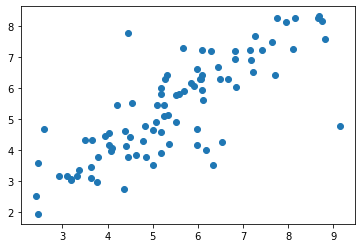

In [338]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.scatter(test_target, test_predict)

In [339]:
LSwFW_model.layers[1].attention_layers[4](train_tensor_scaled)

<tf.Tensor: shape=(354, 1), dtype=float32, numpy=
array([[0.9744031 ],
       [0.9790111 ],
       [0.97858757],
       [0.9786719 ],
       [0.9723006 ],
       [0.9776458 ],
       [0.9764581 ],
       [0.9720961 ],
       [0.88590276],
       [0.864859  ],
       [0.8481729 ],
       [0.8227005 ],
       [0.8393129 ],
       [0.8102953 ],
       [0.81445503],
       [0.7443564 ],
       [0.7465527 ],
       [0.9211513 ],
       [0.91374415],
       [0.8781286 ],
       [0.8507761 ],
       [0.8328528 ],
       [0.8246665 ],
       [0.8800114 ],
       [0.8883621 ],
       [0.8758197 ],
       [0.8087573 ],
       [0.80740994],
       [0.8036174 ],
       [0.79421824],
       [0.79369587],
       [0.79302025],
       [0.74133873],
       [0.7371919 ],
       [0.7656481 ],
       [0.7525875 ],
       [0.74172205],
       [0.7300884 ],
       [0.73483807],
       [0.90777516],
       [0.85193676],
       [0.8425447 ],
       [0.83079493],
       [0.8081655 ],
       [0.8101972 ],
     

In [340]:
attentions=[LSwFW_model.layers[1].attention_layers[i](train_tensor_scaled) for i in range(n_attention)]
attentions=np.hstack(attentions)


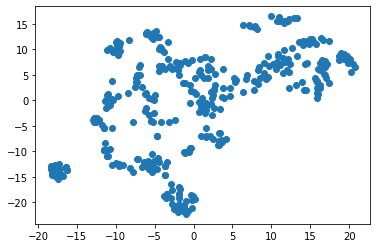

In [341]:
from sklearn.manifold import TSNE

dr=TSNE()
attentions_embed=dr.fit_transform(attentions)

plt.scatter(attentions_embed[:,0], 
         attentions_embed[:,1],
        )

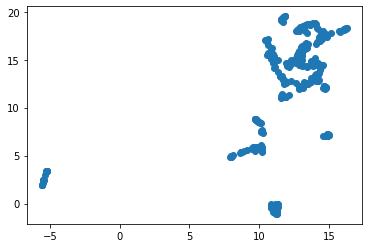

In [342]:
from umap import UMAP

dr=UMAP()
attentions_embed=dr.fit_transform(attentions)

plt.scatter(attentions_embed[:,0],
            attentions_embed[:,1]
           )

Try to color this by clustering from Tanimoto similarity. Is there a way to group them by core compound? Read Ruack's paper in detail